## 4.2. 플럭스 사용법

In [1]:
import MLDatasets
import Flux, NNlib
using Flux: onehotbatch
using MLUtils: DataLoader
using CUDA: has_cuda
import Zygote, Optimisers
using Formatting: printfmtln
using Random: MersenneTwister
import Plots
# 필요 데이터 자동 다운로드
ENV["DATADEPS_ALWAYS_ACCEPT"] = true

true

### 4.2.1. 데이터 준비

In [2]:
function get_data(batchsize = 64)
    xtrain, ytrain = MLDatasets.FashionMNIST(:train)[:]
    xtest, ytest = MLDatasets.FashionMNIST(:test)[:]

    xtrain = reshape(xtrain, 28, 28, 1, :)
    xtest = reshape(xtest, 28, 28, 1, :)

    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    train_loader = DataLoader((xtrain, ytrain), batchsize=batchsize)
    test_loader = DataLoader((xtest, ytest),  batchsize=batchsize)
    
    return train_loader, test_loader
end

get_data (generic function with 2 methods)

### 4.2.2. 모델 생성

In [3]:
function build_mlp_model(rng)
    Flux.Chain(
        Flux.flatten,
        Flux.Dense(28 * 28 => 512, NNlib.relu; init=init(rng)),
        Flux.Dense(512 => 512, NNlib.relu; init=init(rng)),
        Flux.Dense(512 => 10; init=init(rng)),
    )
end

build_mlp_model (generic function with 1 method)

가중치 초기화 함수

In [4]:
init(rng) = Flux.glorot_uniform(rng)

init (generic function with 1 method)

사용자 정의 타입

In [5]:
import Functors
struct MyLinear
    weight
    bias
end
(a::MyLinear)(x) = a.weight * x .+ a.bias # forward method
@Functors.functor MyLinear
Functors.fmap(v -> v * 2, MyLinear([1, 2], [2]))

MyLinear([2, 4], [4])

### 4.2.3. 학습 및 테스트

모델 학습 함수

In [6]:
function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m, X, y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 100 == 0
            loss = loss_fn(model, X, y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]", 
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

train (generic function with 1 method)

모델 테스트 함수

In [7]:
function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        tot += size(X)[end]
        loss += loss_fn(model, X, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", acc, avg_loss)
    acc, avg_loss
end

test (generic function with 1 method)

### 4.2.4. 전체 실행

In [8]:
if has_cuda()
    @info "CUDA is on"
end

rng = MersenneTwister(1)
model = build_mlp_model(rng) |> Flux.gpu

┌ Info: CUDA is on
└ @ Main /home/tyfun/Sources/tms/simjl/book/chap.4/4.2.ipynb:2


Chain(
  Flux.flatten,
  Dense(784 => 512, relu),              # 401_920 parameters
  Dense(512 => 512, relu),              # 262_656 parameters
  Dense(512 => 10),                     # 5_130 parameters
)                   # Total: 6 arrays, 669_706 parameters, 856 bytes.

손실 함수 및 옵티마이저

In [9]:
loss_fn = (m, x, y) -> Flux.Losses.logitcrossentropy(m(x), y)

#15 (generic function with 1 method)

In [10]:
optimizer = Optimisers.setup(Optimisers.Descent(0.001f0), model)

(layers = ((), (weight = Leaf(Descent{Float32}(0.001), nothing), bias = Leaf(Descent{Float32}(0.001), nothing), σ = ()), (weight = Leaf(Descent{Float32}(0.001), nothing), bias = Leaf(Descent{Float32}(0.001), nothing), σ = ()), (weight = Leaf(Descent{Float32}(0.001), nothing), bias = Leaf(Descent{Float32}(0.001), nothing), σ = ())),)

에폭별 실행

In [11]:
function run_epochs(loaders, model, loss_fn, optimizer, epochs)
    train_loader, test_loader = loaders
    train_losses, accuracies = [], [];
    for t in 1:epochs
        println("Epoch $t")
        println("-------------------------------")
        model, optimizer, losses = 
            train(train_loader, model, loss_fn, optimizer)
        train_losses = vcat(train_losses, losses)
        acc, _ = test(test_loader, model, loss_fn)
        push!(accuracies, acc)
    end
    model, train_losses, accuracies
end

run_epochs (generic function with 1 method)

In [12]:
model, losses, accu = run_epochs(get_data(), model, loss_fn, optimizer, 5);

Epoch 1
-------------------------------


[Train] loss: 2

.1345656 [100/938]


[Train] loss: 1.9843962 [200/938]
[Train] loss: 1.7919343 [300/938]
[Train] loss: 1.7712076 [400/938]


[Train] loss: 1.6081719 [500/938]
[Train] loss: 1.5283548 [600/938]


[Train] loss: 1.4786029 [700/938]
[Train] loss: 1.4618611 [800/938]
[Train] loss: 1.2697282 [900/938]


[Test] Accuracy: 66.0, Avg loss: 1.2534885
Epoch 2
-------------------------------
[Train] loss: 1.1759105 [100/938]
[Train] loss: 1.1838014 [200/938]


[Train] loss: 1.0163077 [300/938]
[Train] loss: 1.2045608 [400/938]


[Train] loss: 0.9553252 [500/938]
[Train] loss: 1.0074891 [600/938]
[Train] loss: 1.0611155 [700/938]


[Train] loss: 1.0963756 [800/938]
[Train] loss: 0.9053166 [900/938]
[Test] Accuracy: 71.3, Avg loss: 0.9295497
Epoch 3
-------------------------------


[Train] loss: 0.8986301 [100/938]
[Train] loss: 0.9666405 [200/938]


[Train] loss: 0.7546873 [300/938]
[Train] loss: 1.0307040 [400/938]
[Train] loss: 0.7309926 [500/938]
[Train] loss: 0.8242929 [600/938]


[Train] loss: 0.9186234 [700/938]
[Train] loss: 0.9548765 [800/938]
[Train] loss: 0.7607666 [900/938]


[Test] Accuracy: 74.4, Avg loss: 0.8047462
Epoch 4
-------------------------------
[Train] loss: 0.7915857 [100/938]


[Train] loss: 0.8809574 [200/938]
[Train] loss: 0.6381706 [300/938]
[Train] loss: 0.9519262 [400/938]
[Train] loss: 0.6213716 [500/938]


[Train] loss: 0.7309493 [600/938]
[Train] loss: 0.8472334 [700/938]
[Train] loss: 0.8737152 [800/938]
[Train] loss: 0.6820266 [900/938]


[Test] Accuracy: 76.1, Avg loss: 0.7363338
Epoch 5
-------------------------------
[Train] loss: 0.7302486 [100/938]


[Train] loss: 0.8273523 [200/938]
[Train] loss: 0.5701186 [300/938]
[Train] loss: 0.9025438 [400/938]


[Train] loss: 0.5522949 [500/938]
[Train] loss: 0.6715207 [600/938]
[Train] loss: 0.8020632 [700/938]
[Train] loss: 0.8166626 [800/938]


[Train] loss: 0.6292036 [900/938]
[Test] Accuracy: 77.3, Avg loss: 0.6908692


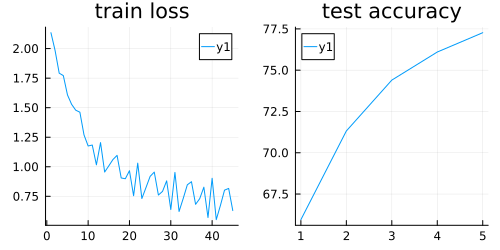

In [13]:
Plots.gr(size=(500,250))
p1 = Plots.plot(losses, title="train loss")
p2 = Plots.plot(accu, title="test accuracy")
Plots.plot(p1, p2)

모델 저장

In [14]:
using BSON: @save
@save "mnist_mlp.bson" m = Flux.cpu(model)

모델 로딩

In [15]:
using BSON: @load
import Flux, NNlib
@load "mnist_mlp.bson" m
m

Chain(
  Flux.flatten,
  Dense(784 => 512, relu),              # 401_920 parameters
  Dense(512 => 512, relu),              # 262_656 parameters
  Dense(512 => 10),                     # 5_130 parameters
)                   # Total: 6 arrays, 669_706 parameters, 2.555 MiB.

로딩된 모델 테스트

In [16]:
import MLDatasets
using Flux: onehotbatch
using MLUtils: DataLoader

function get_data(batchsize = 64)
    xtrain, ytrain = MLDatasets.FashionMNIST(:train)[:]
    xtest, ytest = MLDatasets.FashionMNIST(:test)[:]

    xtrain = reshape(xtrain, 28, 28, 1, :)
    xtest = reshape(xtest, 28, 28, 1, :)

    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    train_loader = DataLoader((xtrain, ytrain), batchsize=batchsize)#, shuffle=true)
    test_loader = DataLoader((xtest, ytest),  batchsize=batchsize)
    
    return train_loader, test_loader
end

_, test_loader = get_data()
(X, y) = first(test_loader)
Flux.onecold(m(X)).-1, Flux.onecold(y).-1

([9, 2, 1, 1, 6, 1, 4, 4, 7, 7  …  4, 2, 8, 4, 8, 0, 7, 7, 8, 5], [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  2, 2, 8, 4, 8, 0, 7, 7, 8, 5])